In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
import theano
THEANO_FLAGS="optimizer=fast_compile"

In [2]:
#example on how to simplify an ODE function with many parameters

def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0]

t = np.arange(0, 10)
params = [[0.4, 9.8]]
y0 = 0
y = odeint(freefall, t=t, y0=y0, args=tuple(params))

#plt.plot(t, y, label="speed", color="k", alpha=0.5)
#plt.show()

In [ ]:
yobs = np.random.normal(y, 5)

plt.plot(t, yobs, label="observed speed", linestyle="dashed", marker="o", color="red")
plt.plot(t, y, label="speed", color="k", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
ode_model = DifferentialEquation(func=freefall, times=t, n_states=1, n_theta=2, t0=0)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    #sigma = pm.HalfCauchy("sigma", 1)
    #gamma = pm.Lognormal("gamma", 0, 1)
    sigma = pm.Uniform("sigma", 0, 1)
    gamma = pm.Uniform("gamma", 0, 1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
data = az.from_pymc3(trace=trace)

In [ ]:
az.plot_posterior(data, round_to=2)

#### Another Example

In [ ]:
class Chem:
    
    @staticmethod
    def reaction(y, t, p):
        S, P = y[0], y[1]
        vmax, K_S = p[0], p[1]
        dPdt = vmax * (S / K_S + S)
        dSdt = -dPdt
        return [dSdt, dPdt]

times = np.arange(0, 10, 0.5)

y0_true = (10, 2)
theta_true = vmax, K_S = (0.5, 2)
sigma = 0.5

y_obs = odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
y_obs_1 = np.random.normal(y_obs[:, 0], sigma)
y_obs_2 = np.random.normal(y_obs[:, 1], sigma)

plt.plot(times, y_obs_1, label="S", linestyle="dashed", marker="o", color="red")
plt.plot(times, y_obs_2, label="P", linestyle="dashed", marker="o", color="blue")
plt.legend()
plt.xlabel("Time (Seconds)")
plt.ylabel(r"$y(t)$")
sns.despine()

In [ ]:
with pm.Model() as pmodel:
    sigma = pm.HalfCauchy("sigma", 1)
    vmax = pm.Lognormal("vmax", 0, 1)
    K_S = pm.Lognormal("K_S", 0, 1)
    s0 = pm.Normal("red_0", mu=10, sd=2)

    y_hat = pm.ode.DifferentialEquation(
        func=Chem.reaction, times=times, n_states=len(y0_true), n_theta=len(theta_true)
    )(y0=[s0, y0_true[1]], theta=[vmax, K_S], return_sens=False)

    red_hat = y_hat.T[0]
    blue_hat = y_hat.T[1]

    Y_red = pm.Normal("Y_red", mu=red_hat, sd=sigma, observed=y_obs_1)
    Y_blue = pm.Normal("Y_blue", mu=blue_hat, sd=sigma, observed=y_obs_2)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=1, step=step)
    
    #posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
with pmodel:
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
sigma1_samples = trace["sigma"][0:, None]
sigma2_samples = trace["sigma"][2000:, None]

In [ ]:
plt.subplot(211)
plt.hist(sigma1_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.hist(sigma2_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density')

In [ ]:
plt.plot(sigma1_samples, color = 'darkred')
plt.show()

#### ODE Models

In [9]:
#static model
def hill_activation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

#growth curve
def od_inference(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    solution = odeint(od_model, c0, t, (r, c))
    return np.array(solution[:,0])

#model only auto-fluorescence
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only GFP
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

In [ ]:
def model_fit(t, j):
    fit = gate_wrapper_auto(t, j, ind1, ind2, (o_params[0], o_params[1]), [0, o_params[2]])
    return pd.Series(fit[0])

#### Marionette Strain

In [2]:
fluos = pd.read_csv('datasets/marionette_fluo_half.csv', index_col='time')
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
gates = list(set([i[:-3] for i in fluos.columns.tolist()]))
fluos.shape, ods.shape

((73, 48), (73, 48))

In [3]:
gates

['negative_control',
 'positive_control',
 'e32x30SspGyrB',
 'e11x32STPhoRadA',
 'e20x32gp411',
 'e34x30MjaKlbA',
 'e41x32NrdJ1',
 'e16x33NrdA2',
 'blank',
 'e38x32gp418',
 'e42x32STIMPDH1',
 'e15x32NpuSspS2']

In [4]:
sel = 3
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

3 e11x32STPhoRadA


In [90]:
fluo = fluo_sel.iloc[:,3]
od = od_sel.iloc[:,3]

In [10]:
par = {
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}
o_p0 = [i[0] for i in list(par.values())]
o_bounds = [[i[1] for i in list(par.values())], [i[2] for i in list(par.values())]]
o_params, o_cov = curve_fit(od_inference, od.index, od, bounds=o_bounds)
o_params

array([0.01555375, 1.27816437, 0.02386447])

In [ ]:
class SGNModel:
    
    @staticmethod
    def od_model(y, t, p):
        dOD = growth_rate(t, y[0], p[0], p[1]) * y[0]
        return [dOD]
    
    @staticmethod
    def growth_rate(t, y, a, b):
        return (a * (1 - (y/b)))
    

with pm.Model() as od_model:
    
    alpha = pm.Uniform('alpha', 0, 1)
    beta = pm.Uniform('beta', 0, 2)
    c0 = pm.Uniform('c0', 0, 0.1)
    
    
    y_hat = pm.ode.DifferentialEquation(
        func=GeneCircuit.od_model, times=od.index, n_states=1, n_theta=2
    )(y0=[c0], theta=[alpha, beta])
    
    od_est = pm.Normal('od', mu=y_hat.T[0], sd=0.2, observed=od)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

In [62]:
def hill_equation(x, K, n):
        return x**n / (K**n + x**n)

def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, y0):
    
    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP = y
        ind1, ind2 = 1, 1
        
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def model_fit(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n):
    
    fit = gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, [0, 0, 0, 0])
    return pd.Series(fit[3])

In [119]:
class SGNModel:
    
    @staticmethod
    def hill_equation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def gate_model_no_auto(y, t, p):
        
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10]
        ECFn, ECFc, ECF, GFP = y[0], y[1], y[2], y[3]
        ind1, ind2 = 1, 1
        
        #gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        #dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]

with pm.Model() as od_model:
    
    bn = 2#bn = pm.Uniform('bn', 0, 1e1)
    bc = 2#bc = pm.Uniform('bc', 0, 1e1)
    bg = 2#bg = pm.Uniform('bg', 0, 1e1)
    syn_ECFn = 50#syn_ECFn = pm.Uniform('syn_ECFn', 0, 1e2)
    syn_ECFc = 50#syn_ECFc = pm.Uniform('syn_ECFc', 0, 1e2)
    syn_ECF = pm.Uniform('syn_ECF', 0, 1e-4)
    syn_GFP = pm.Uniform('syn_GFP', 0, 1e-1)
    deg = 0.05#deg = pm.Uniform('deg', 0, 1e5)
    deg_GFP = 0.05#deg_GFP = pm.Uniform('deg_GFP', 0, 1e0)
    K = 10#K = pm.Uniform('K', 0, 1e2)
    n = 4#n = pm.Uniform('n', 0, 4)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [syn_GFP]
>Metropolis: [syn_ECF]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6495 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [120]:
data = az.from_pymc3(trace=trace)

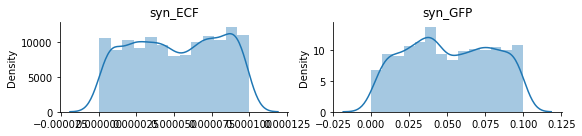

In [121]:
pars = ['syn_ECF', 'syn_GFP']
f, axs = plt.subplots(1, 2, figsize=(8, 2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(pars):
        #ax.hist(trace[pars[i]], bins=30)
        sns.distplot(trace[pars[i]], ax=ax)
        ax.set_title(pars[i])
plt.tight_layout()
sns.despine()

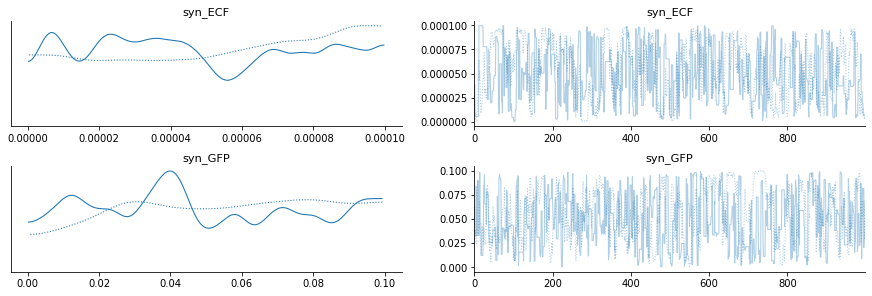

In [122]:
az.plot_trace(data)
sns.despine()

In [18]:
class SGNModel:
    
    @staticmethod
    def hill_equation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def gfp_only_model(y, t, p):
        
        #dependent variables
        Auto, OD = y[0], y[1]
        #a = p[0]
        #alpha, beta = extra
        a, alpha, beta = p[0], p[1], p[2]
        
        gamma = SGNModel.growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    @staticmethod
    def gate_model_no_auto(y, t, p):
        
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10]
        ECFn, ECFc, ECF, GFP = y[0], y[1], y[2], y[3]
        ind1, ind2 = 1, 1
        
        #gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        #dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]
'''
with pm.Model() as od_model:
    
    #alpha = pm.Uniform('alpha', 0, 1)
    #beta = pm.Uniform('beta', 0, 2)
    #c0 = pm.Uniform('c0', 0, 0.1)
    
    alpha, beta, c0 = o_params
    a = pm.Uniform('a', 0, 200)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gfp_only_model, times=fluo.index, n_states=2, n_theta=3
    )(y0=[0, c0], theta=[a, alpha, beta])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.2, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)
'''

with pm.Model() as od_model:
    
    bn = pm.Uniform('bn', 0, 1e1)
    bc = pm.Uniform('bc', 0, 1e1)
    bg = pm.Uniform('bg', 0, 1e1)
    syn_ECFn = pm.Uniform('syn_ECFn', 0, 1e2)
    syn_ECFc = pm.Uniform('syn_ECFc', 0, 1e2)
    syn_ECF = pm.Uniform('syn_ECF', 0, 1e-4)
    syn_GFP = pm.Uniform('syn_GFP', 0, 1e-1)
    deg = pm.Uniform('deg', 0, 1e5)
    deg_GFP = pm.Uniform('deg_GFP', 0, 1e0)
    K = pm.Uniform('K', 0, 1e2)
    n = pm.Uniform('n', 0, 4)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [K]
>Metropolis: [deg_GFP]
>Metropolis: [deg]
>Metropolis: [syn_GFP]
>Metropolis: [syn_ECF]
>Metropolis: [syn_ECFc]
>Metropolis: [syn_ECFn]
>Metropolis: [bg]
>Metropolis: [bc]
>Metropolis: [bn]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72902 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [115]:
pars = {
    'bn': 9.980960e+00,
    'bc': 4.873768e+00,
    'bg': 5.160116e+00,
    'syn_ECFn': 9.989766e+01,
    'syn_ECFc': 5.087405e+01,
    'syn_ECF': 9.844930e-09,
    'syn_GFP': 9.351119e-03,
    'deg': 3.627036e+03,
    'deg_GFP': 1.347098e-01,
    'K': 4.908509e+01,
    'n': 2.490464e+00
}
errs = {
    'bn': 1.282754e-01,
    'bc': 1.242285e+01,
    'bg': 1.022647e+00,
    'syn_ECFn': 4.283182e+00,
    'syn_ECFc': 2.649231e+01,
    'syn_ECF': 1.152230e-08,
    'syn_GFP': 9.366010e-03,
    'deg': 9.459877e-03,
    'deg_GFP': 2.046354e-01,
    'K': 3.432406e+01,
    'n': 2.512038e+00
}

with pm.Model() as od_model:
    
    bn = pm.Normal('bn', mu=pars['bn'], sigma=errs['bn'])
    bc = pm.Normal('bc', mu=pars['bc'], sigma=errs['bc'])
    bg = pm.Normal('bg', mu=pars['bg'], sigma=errs['bg'])
    syn_ECFn = pm.Normal('syn_ECFn', mu=pars['syn_ECFn'], sigma=errs['syn_ECFn'])
    syn_ECFc = pm.Normal('syn_ECFc', mu=pars['syn_ECFc'], sigma=errs['syn_ECFc'])
    syn_ECF = pm.Normal('syn_ECF', mu=pars['syn_ECF'], sigma=errs['syn_ECF'])
    syn_GFP = pm.Normal('syn_GFP', mu=pars['syn_GFP'], sigma=errs['syn_GFP'])
    deg = pm.Normal('deg', mu=pars['deg'], sigma=errs['deg'])
    deg_GFP = pm.Normal('deg_GFP', mu=pars['deg_GFP'], sigma=errs['deg_GFP'])
    K = pm.Normal('K', mu=pars['K'], sigma=errs['K'])
    n = pm.Normal('n', mu=pars['n'], sigma=errs['n'])
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, chains=1, cores=1, step=step)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [K]
>Metropolis: [deg_GFP]
>Metropolis: [deg]
>Metropolis: [syn_GFP]
>Metropolis: [syn_ECF]
>Metropolis: [syn_ECFc]
>Metropolis: [syn_ECFn]
>Metropolis: [bg]
>Metropolis: [bc]
>Metropolis: [bn]


Sampling 1 chain for 1 tune and 0 draw iterations (1 + 0 draws total) took 62 seconds.
No posterior samples. Unable to run convergence checks


In [19]:
data = az.from_pymc3(trace=trace)

In [20]:
data.to_netcdf('datasets/first-bayesian.nc')

'datasets/first-bayesian.nc'

In [103]:
from datetime import datetime
print('gate' + datetime.now().strftime("%Y%m%d"))

gate20210711


In [109]:
gates

['e20x32gp411',
 'negative_control',
 'blank',
 'e32x30SspGyrB',
 'positive_control',
 'e38x32gp418',
 'e34x30MjaKlbA',
 'e15x32NpuSspS2',
 'e41x32NrdJ1',
 'e11x32STPhoRadA',
 'e42x32STIMPDH1',
 'e16x33NrdA2']

In [31]:
pars = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'syn_GFP', 'deg', 'deg_GFP', 'K', 'n']

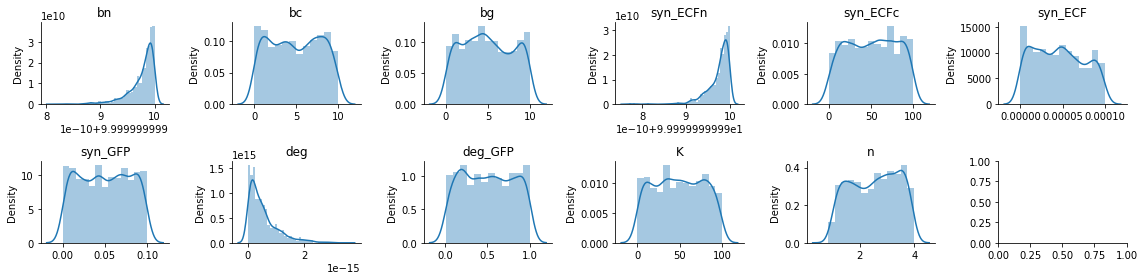

In [45]:
f, axs = plt.subplots(2, 6, figsize=(16, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(pars):
        #ax.hist(trace[pars[i]], bins=30)
        sns.distplot(trace[pars[i]], ax=ax)
        ax.set_title(pars[i])
plt.tight_layout()
sns.despine()

In [65]:
gate

'e20x32gp411'

In [51]:
mean_pars = {}
for p in pars:
    mean_pars[p] = trace[p][:,None].mean()#print(p, trace[p][:,None].mean())
mean_pars

{'bn': 9.999999999976385,
 'bc': 4.884941174143677,
 'bg': 4.964135672597076,
 'syn_ECFn': 99.9999999999739,
 'syn_ECFc': 50.97696503335078,
 'syn_ECF': 4.576133462199827e-05,
 'syn_GFP': 0.049953121728744096,
 'deg': 5.398089262804092e-16,
 'deg_GFP': 0.5074861557143704,
 'K': 48.96930082383338,
 'n': 2.5313510745154546}

#### Load Data

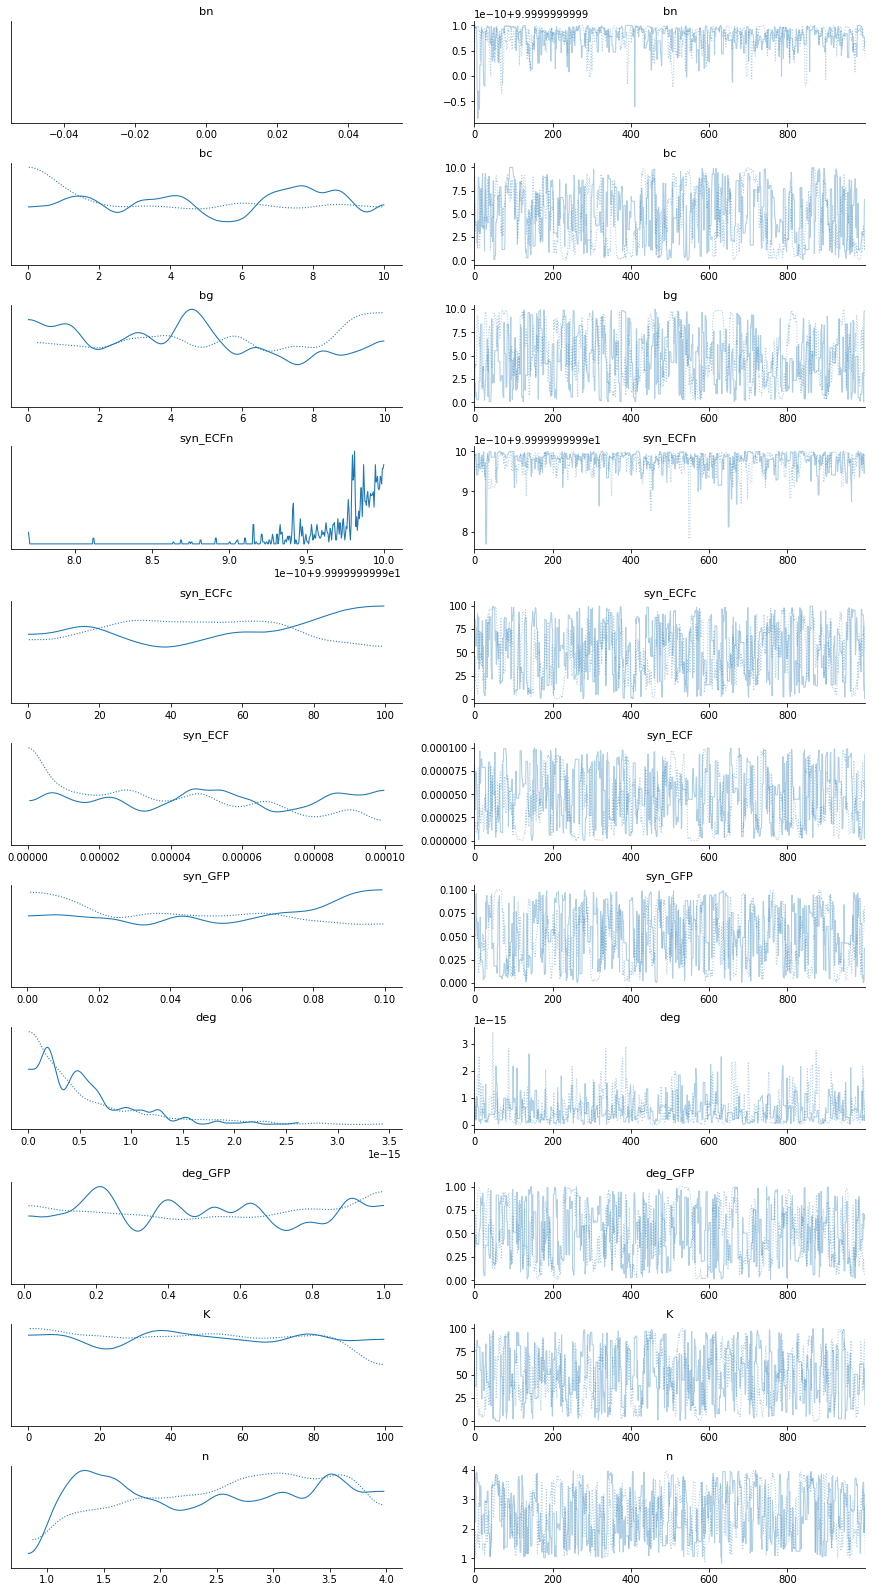

In [8]:
loaded = az.from_netcdf('datasets/first-bayesian.nc')
az.plot_trace(loaded)
sns.despine()

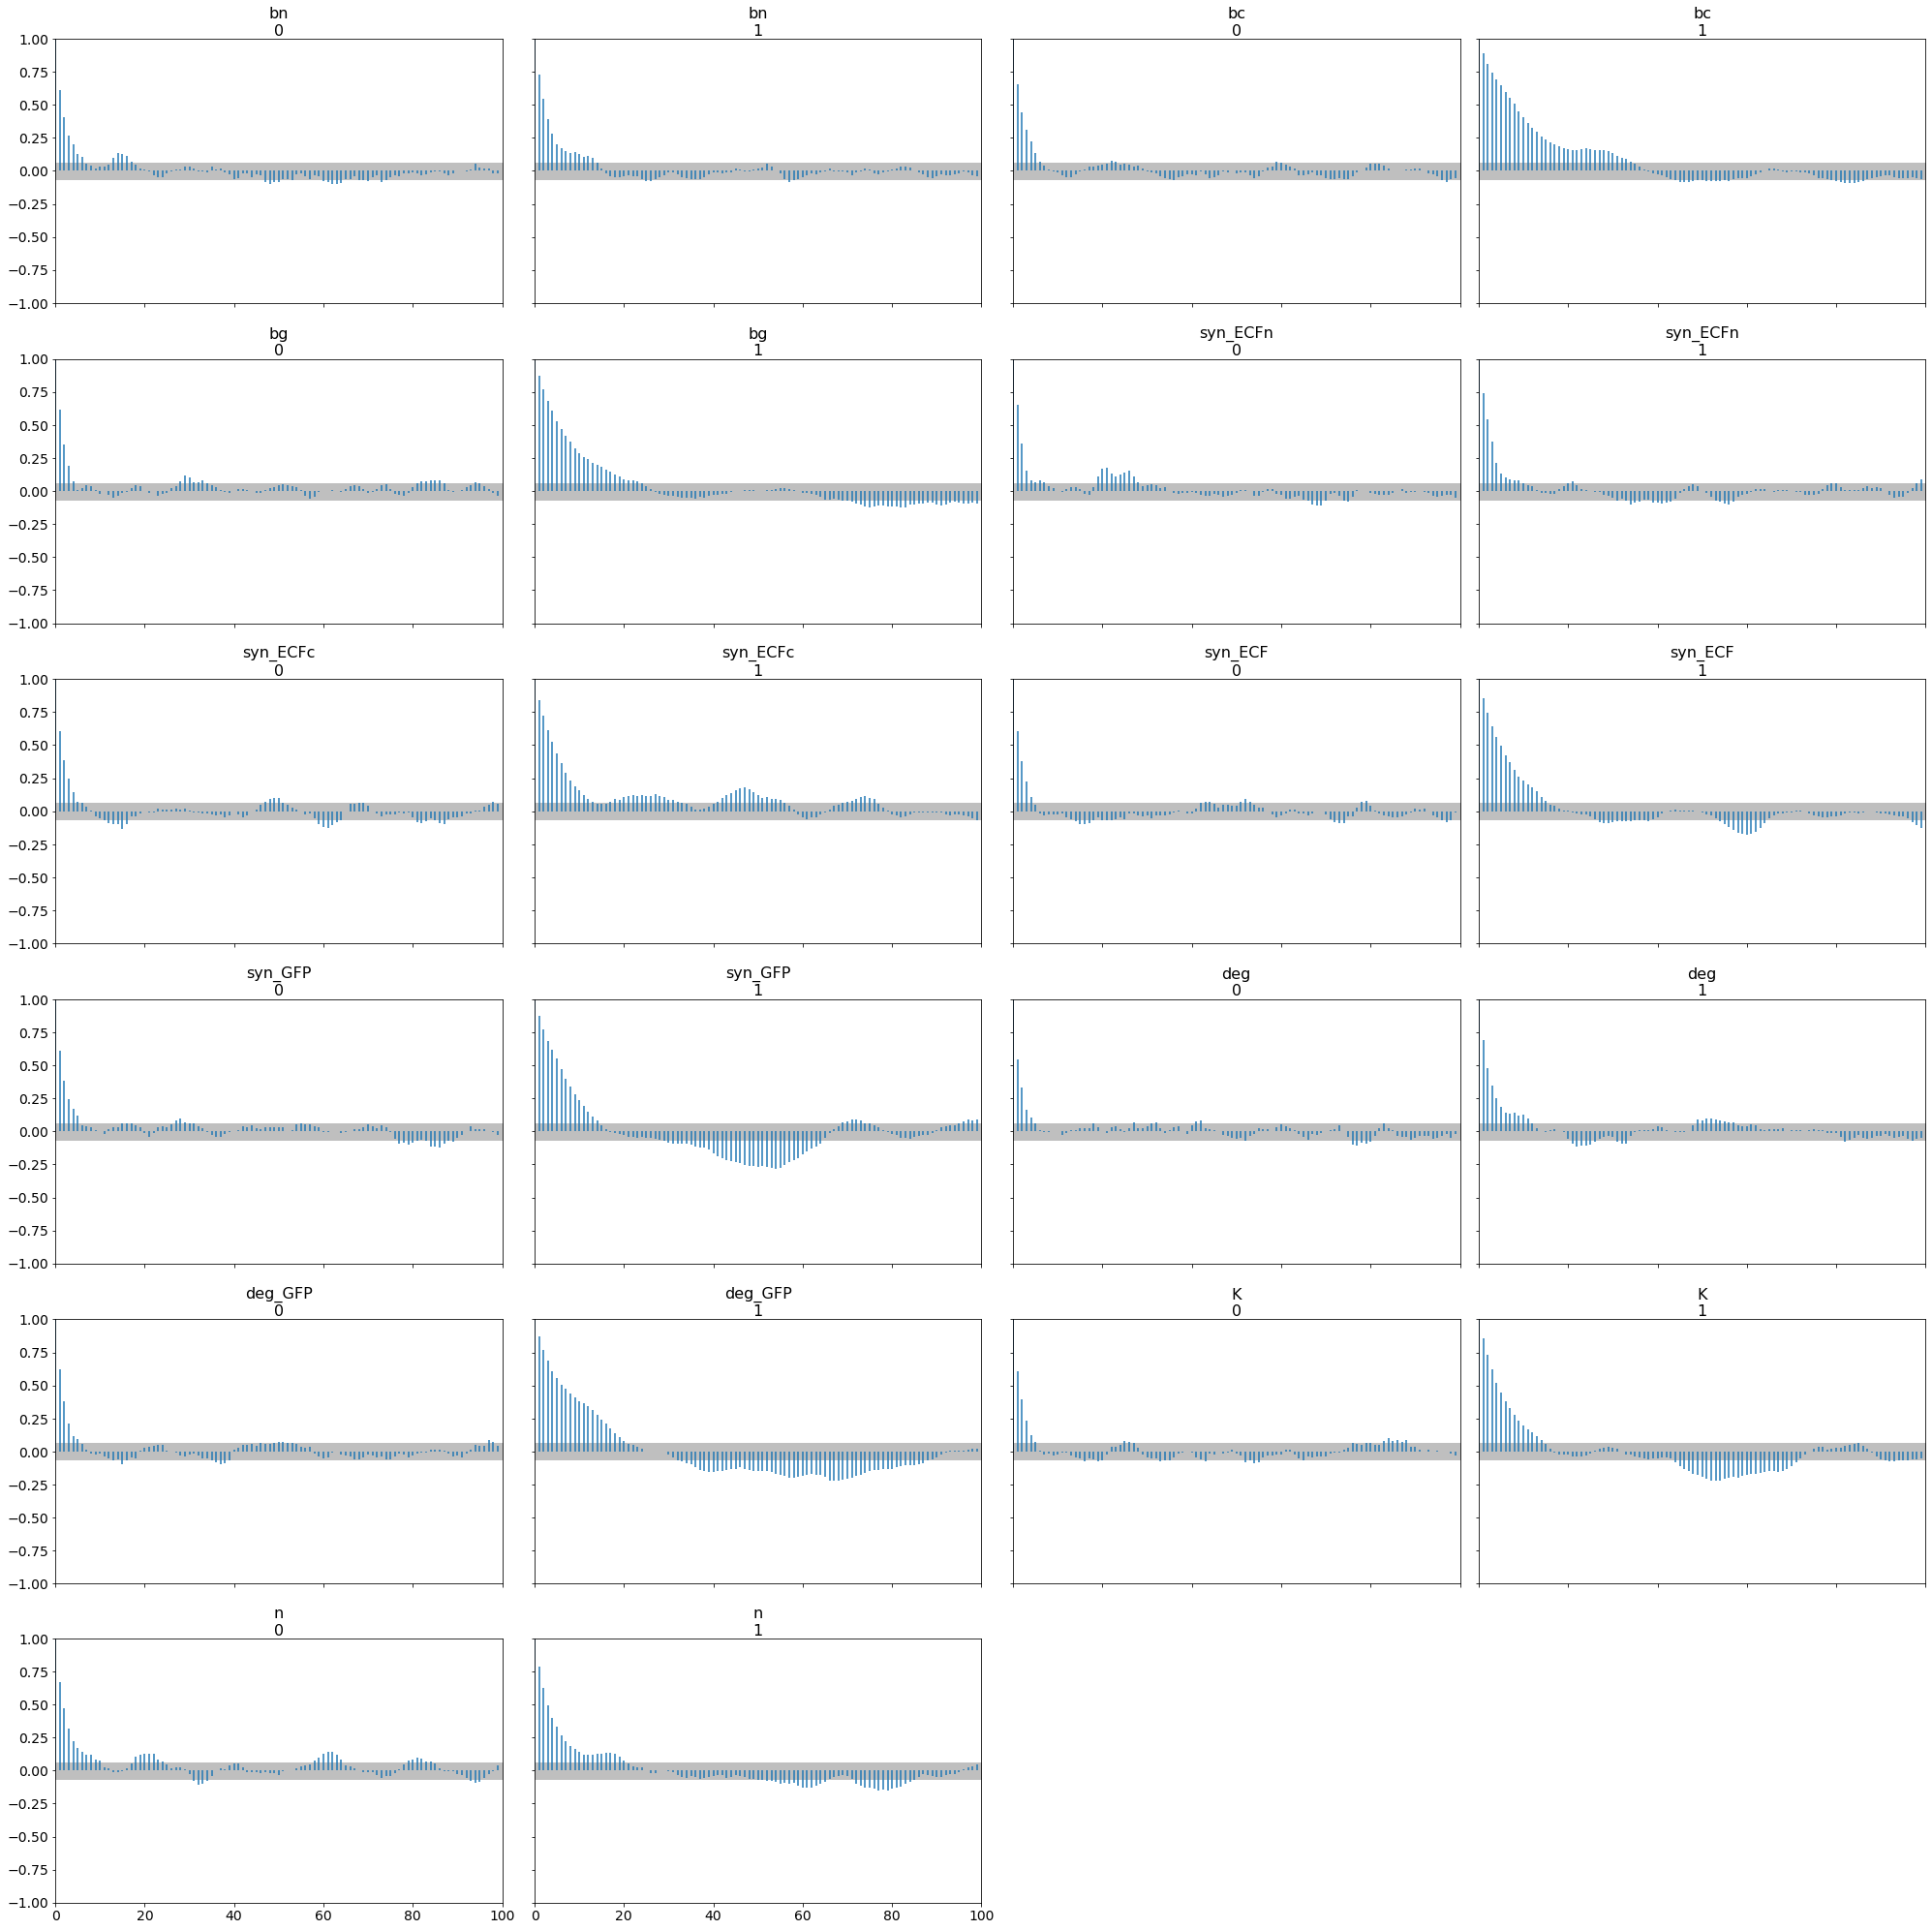

In [9]:
az.plot_autocorr(loaded)
plt.show()

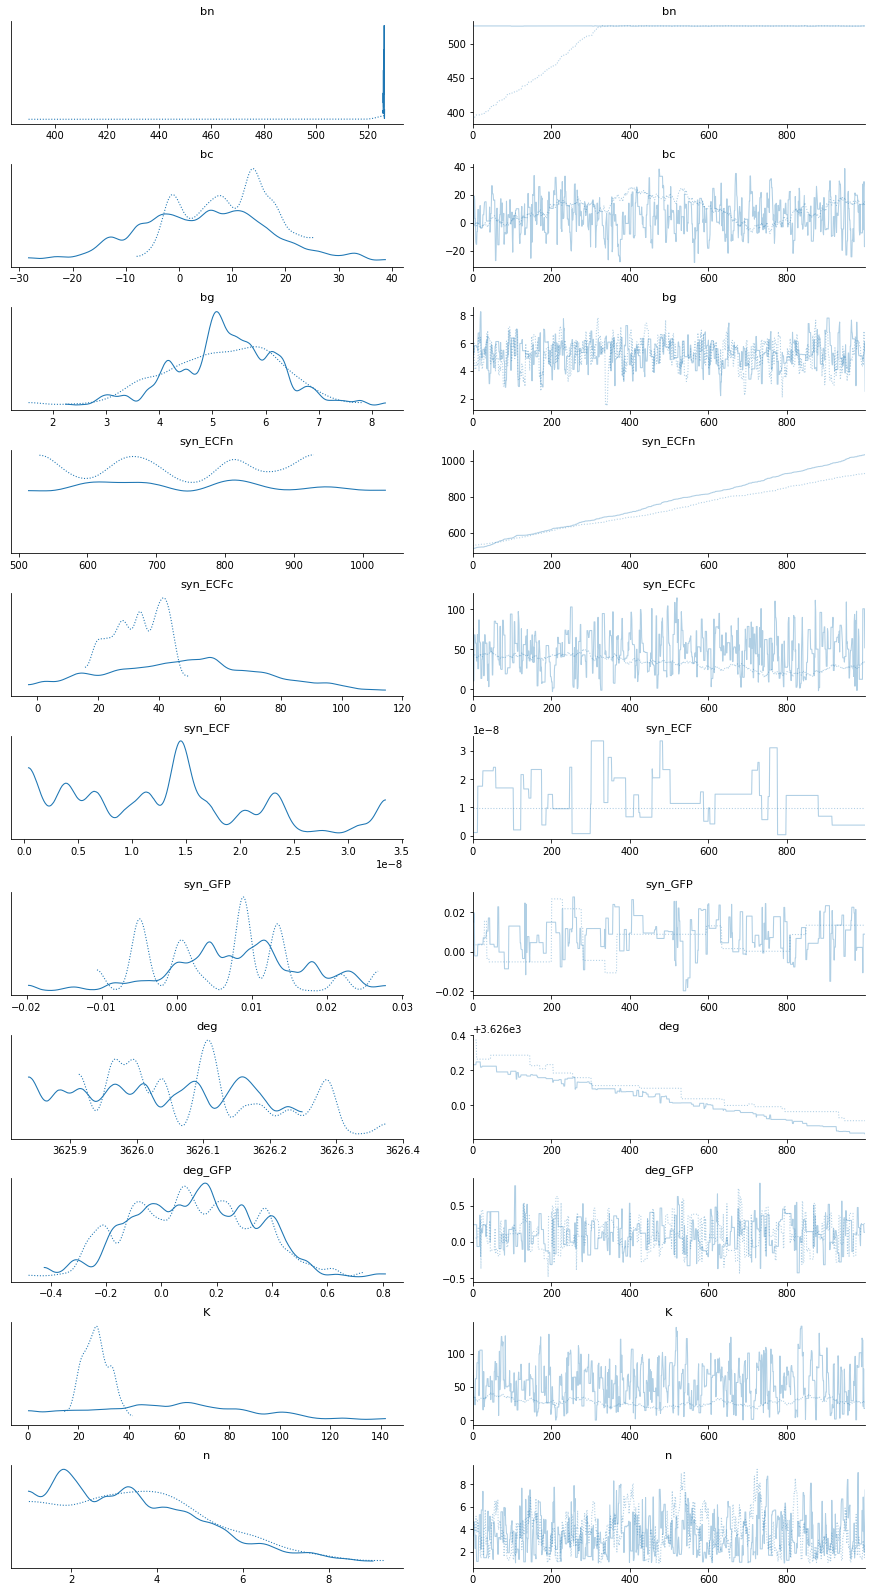

In [5]:
loaded = az.from_netcdf('datasets/e11x32STPhoRadA-20210716.nc')
az.plot_trace(loaded)
sns.despine()

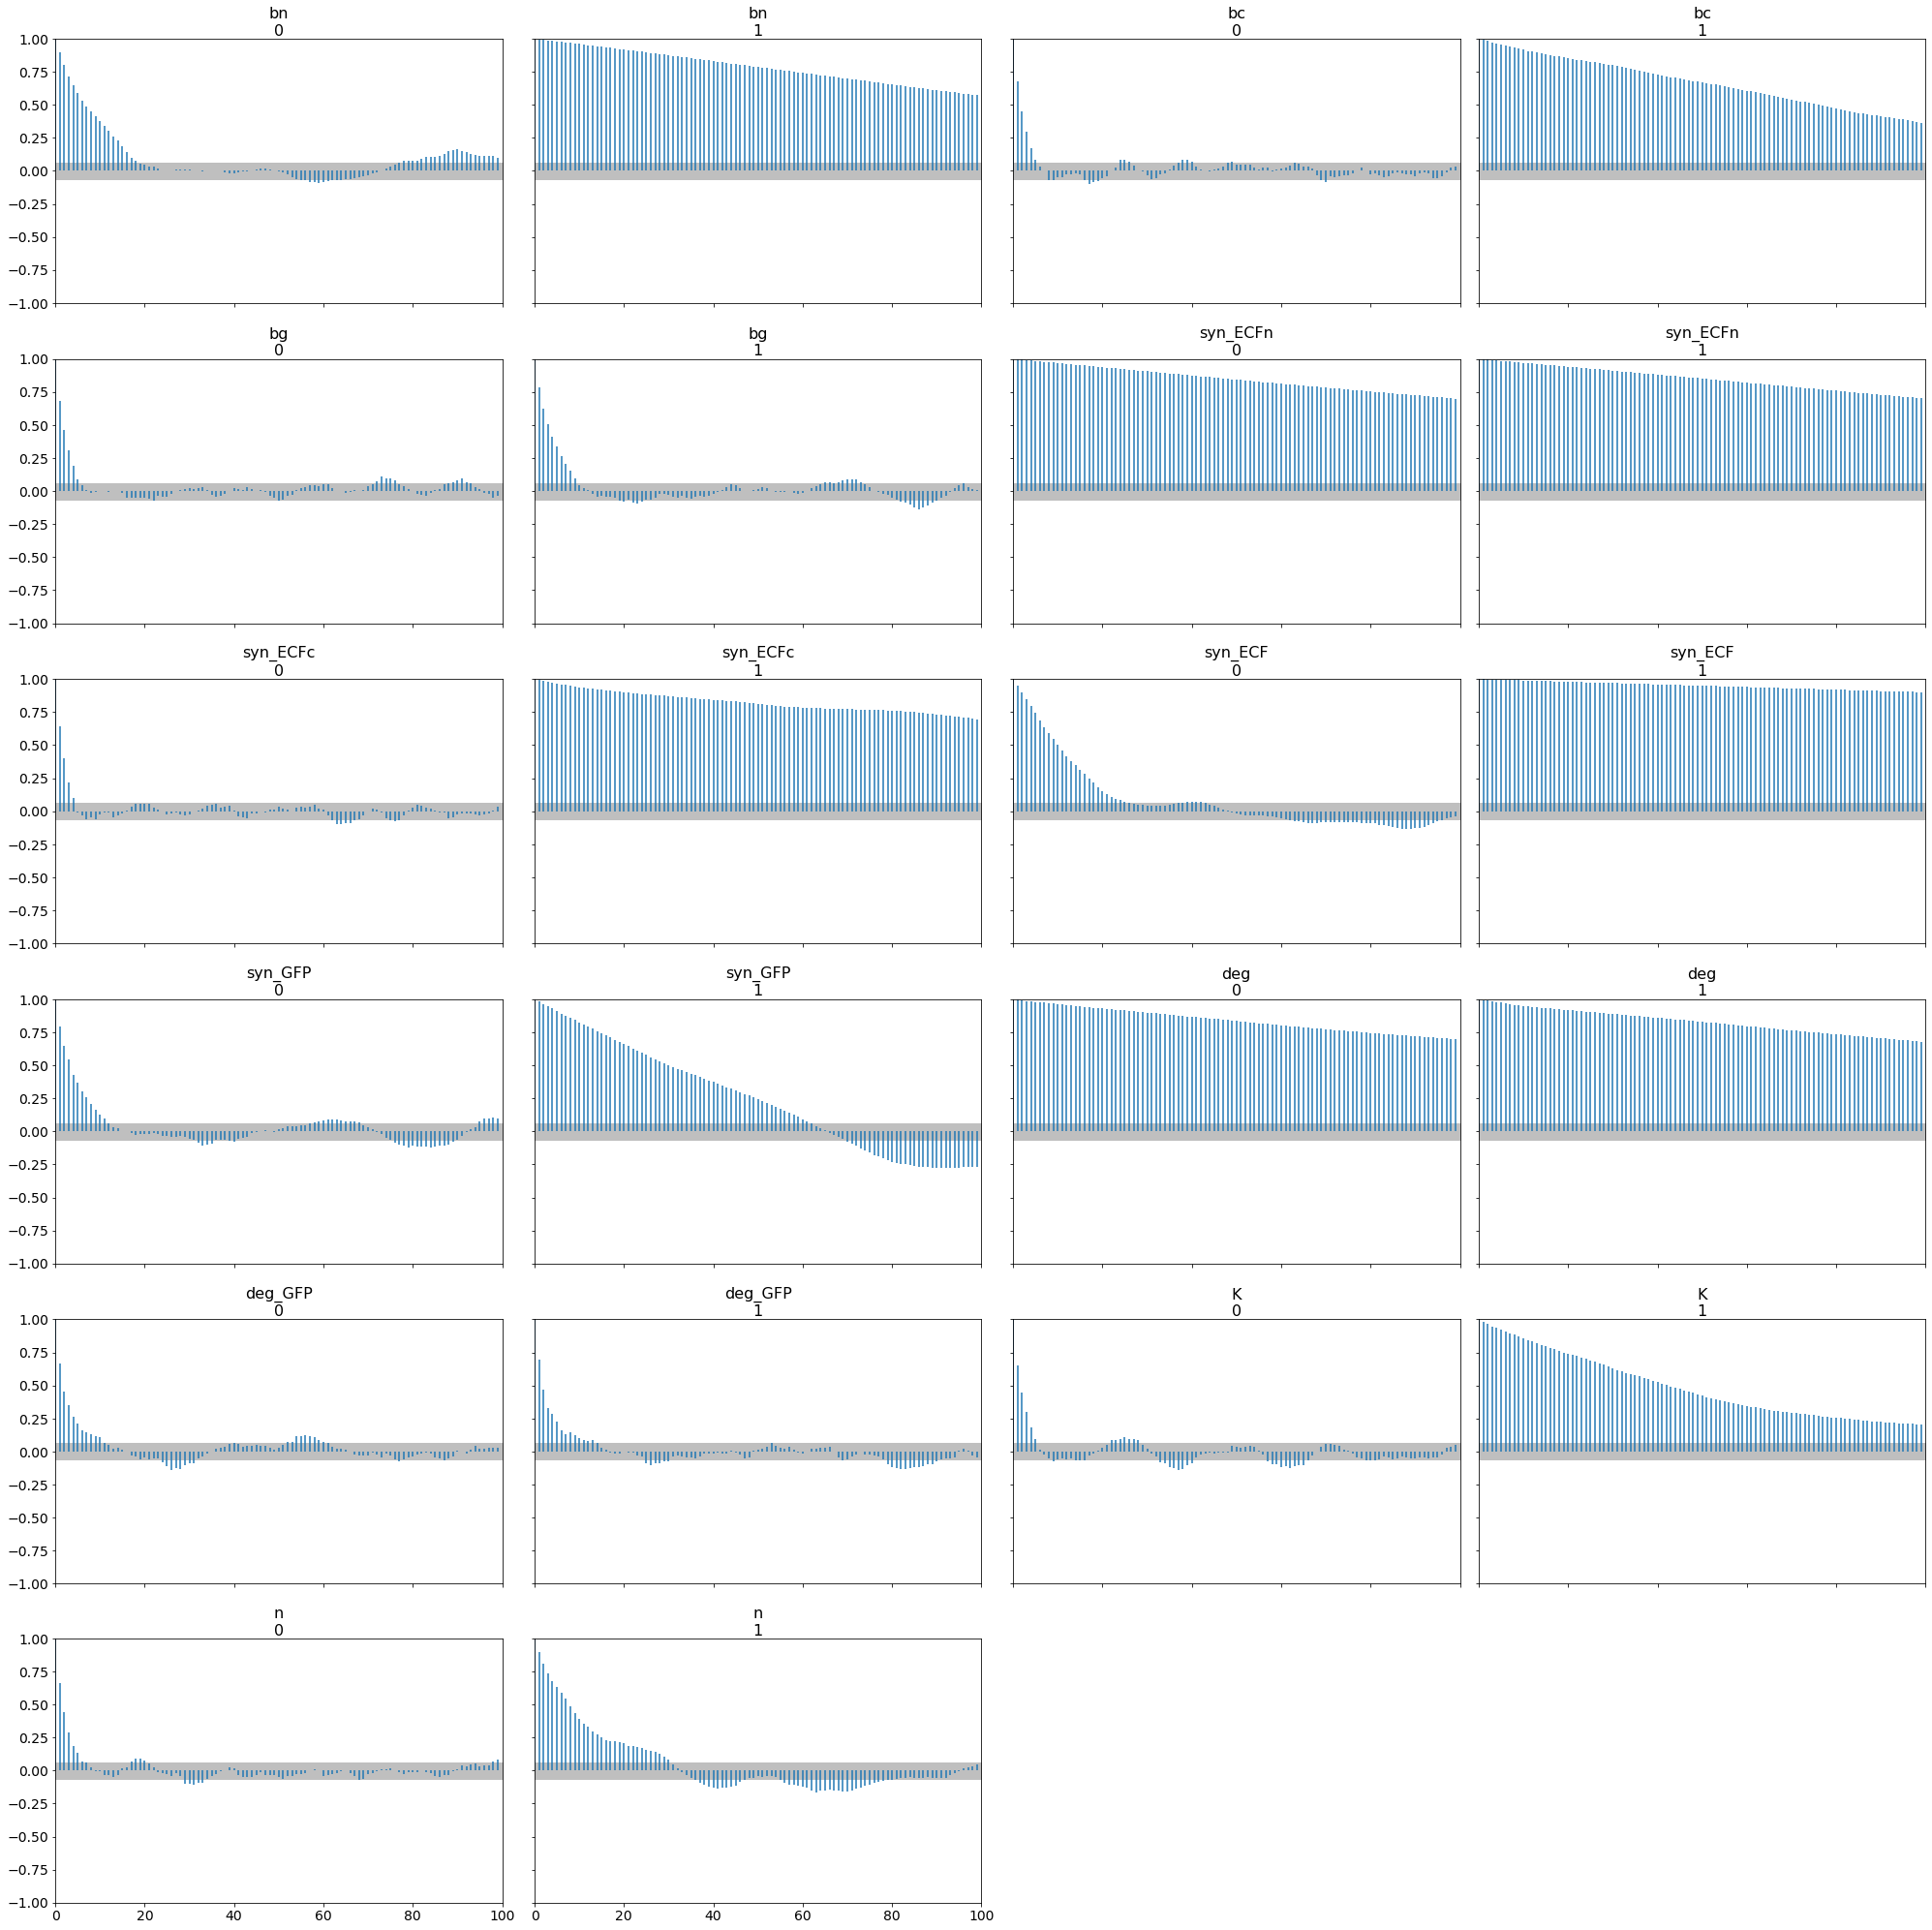

In [6]:
az.plot_autocorr(loaded)
plt.show()

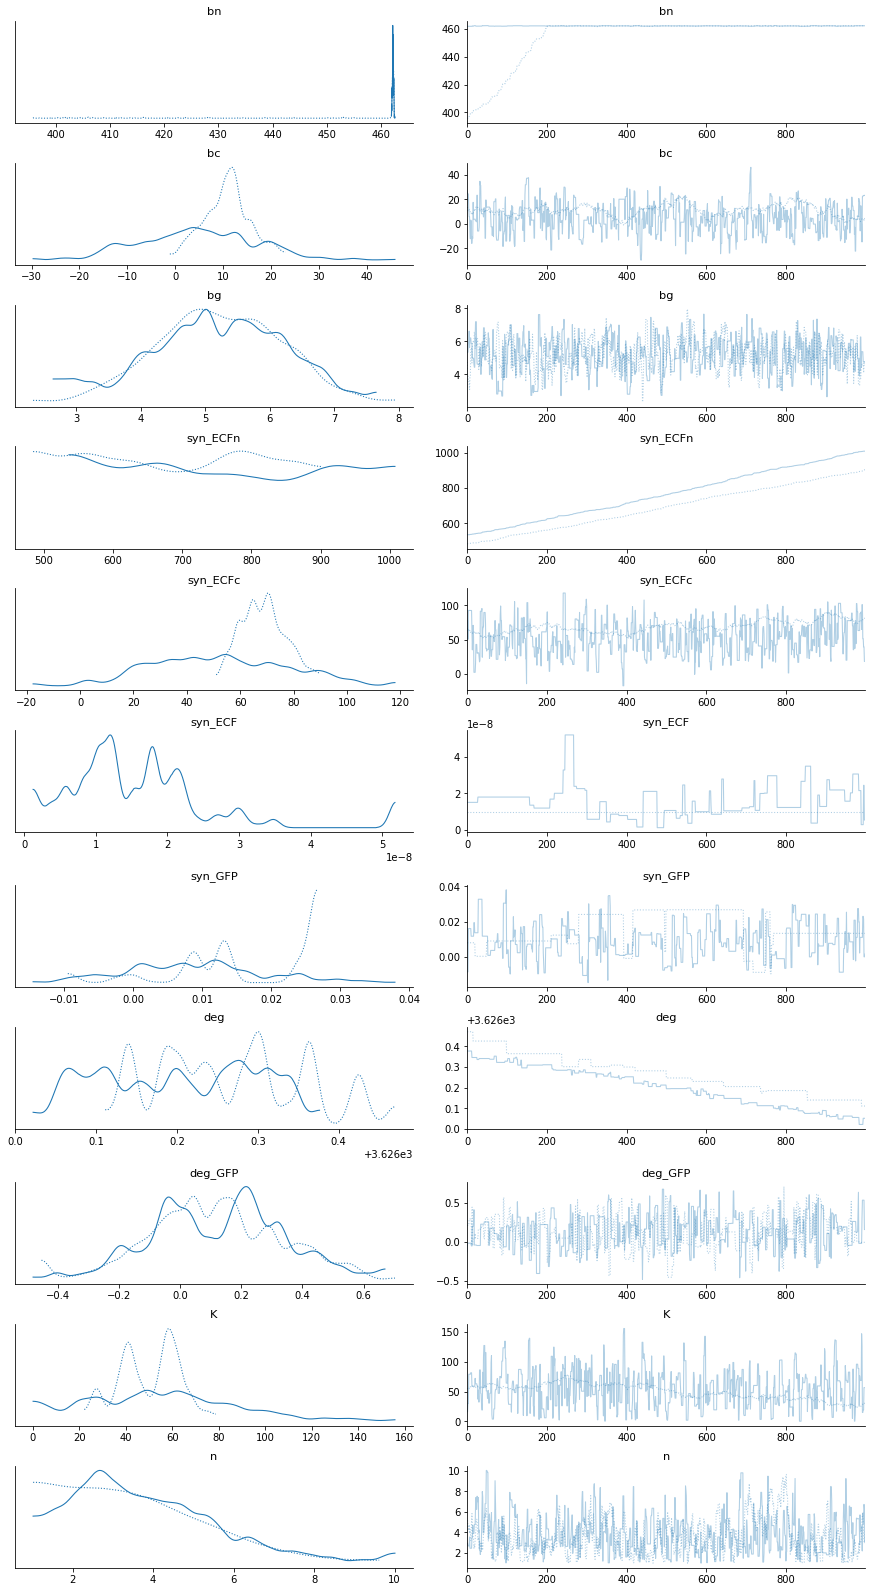

In [7]:
loaded = az.from_netcdf('datasets/e42x32STIMPDH1-20210714.nc')
az.plot_trace(loaded)
sns.despine()

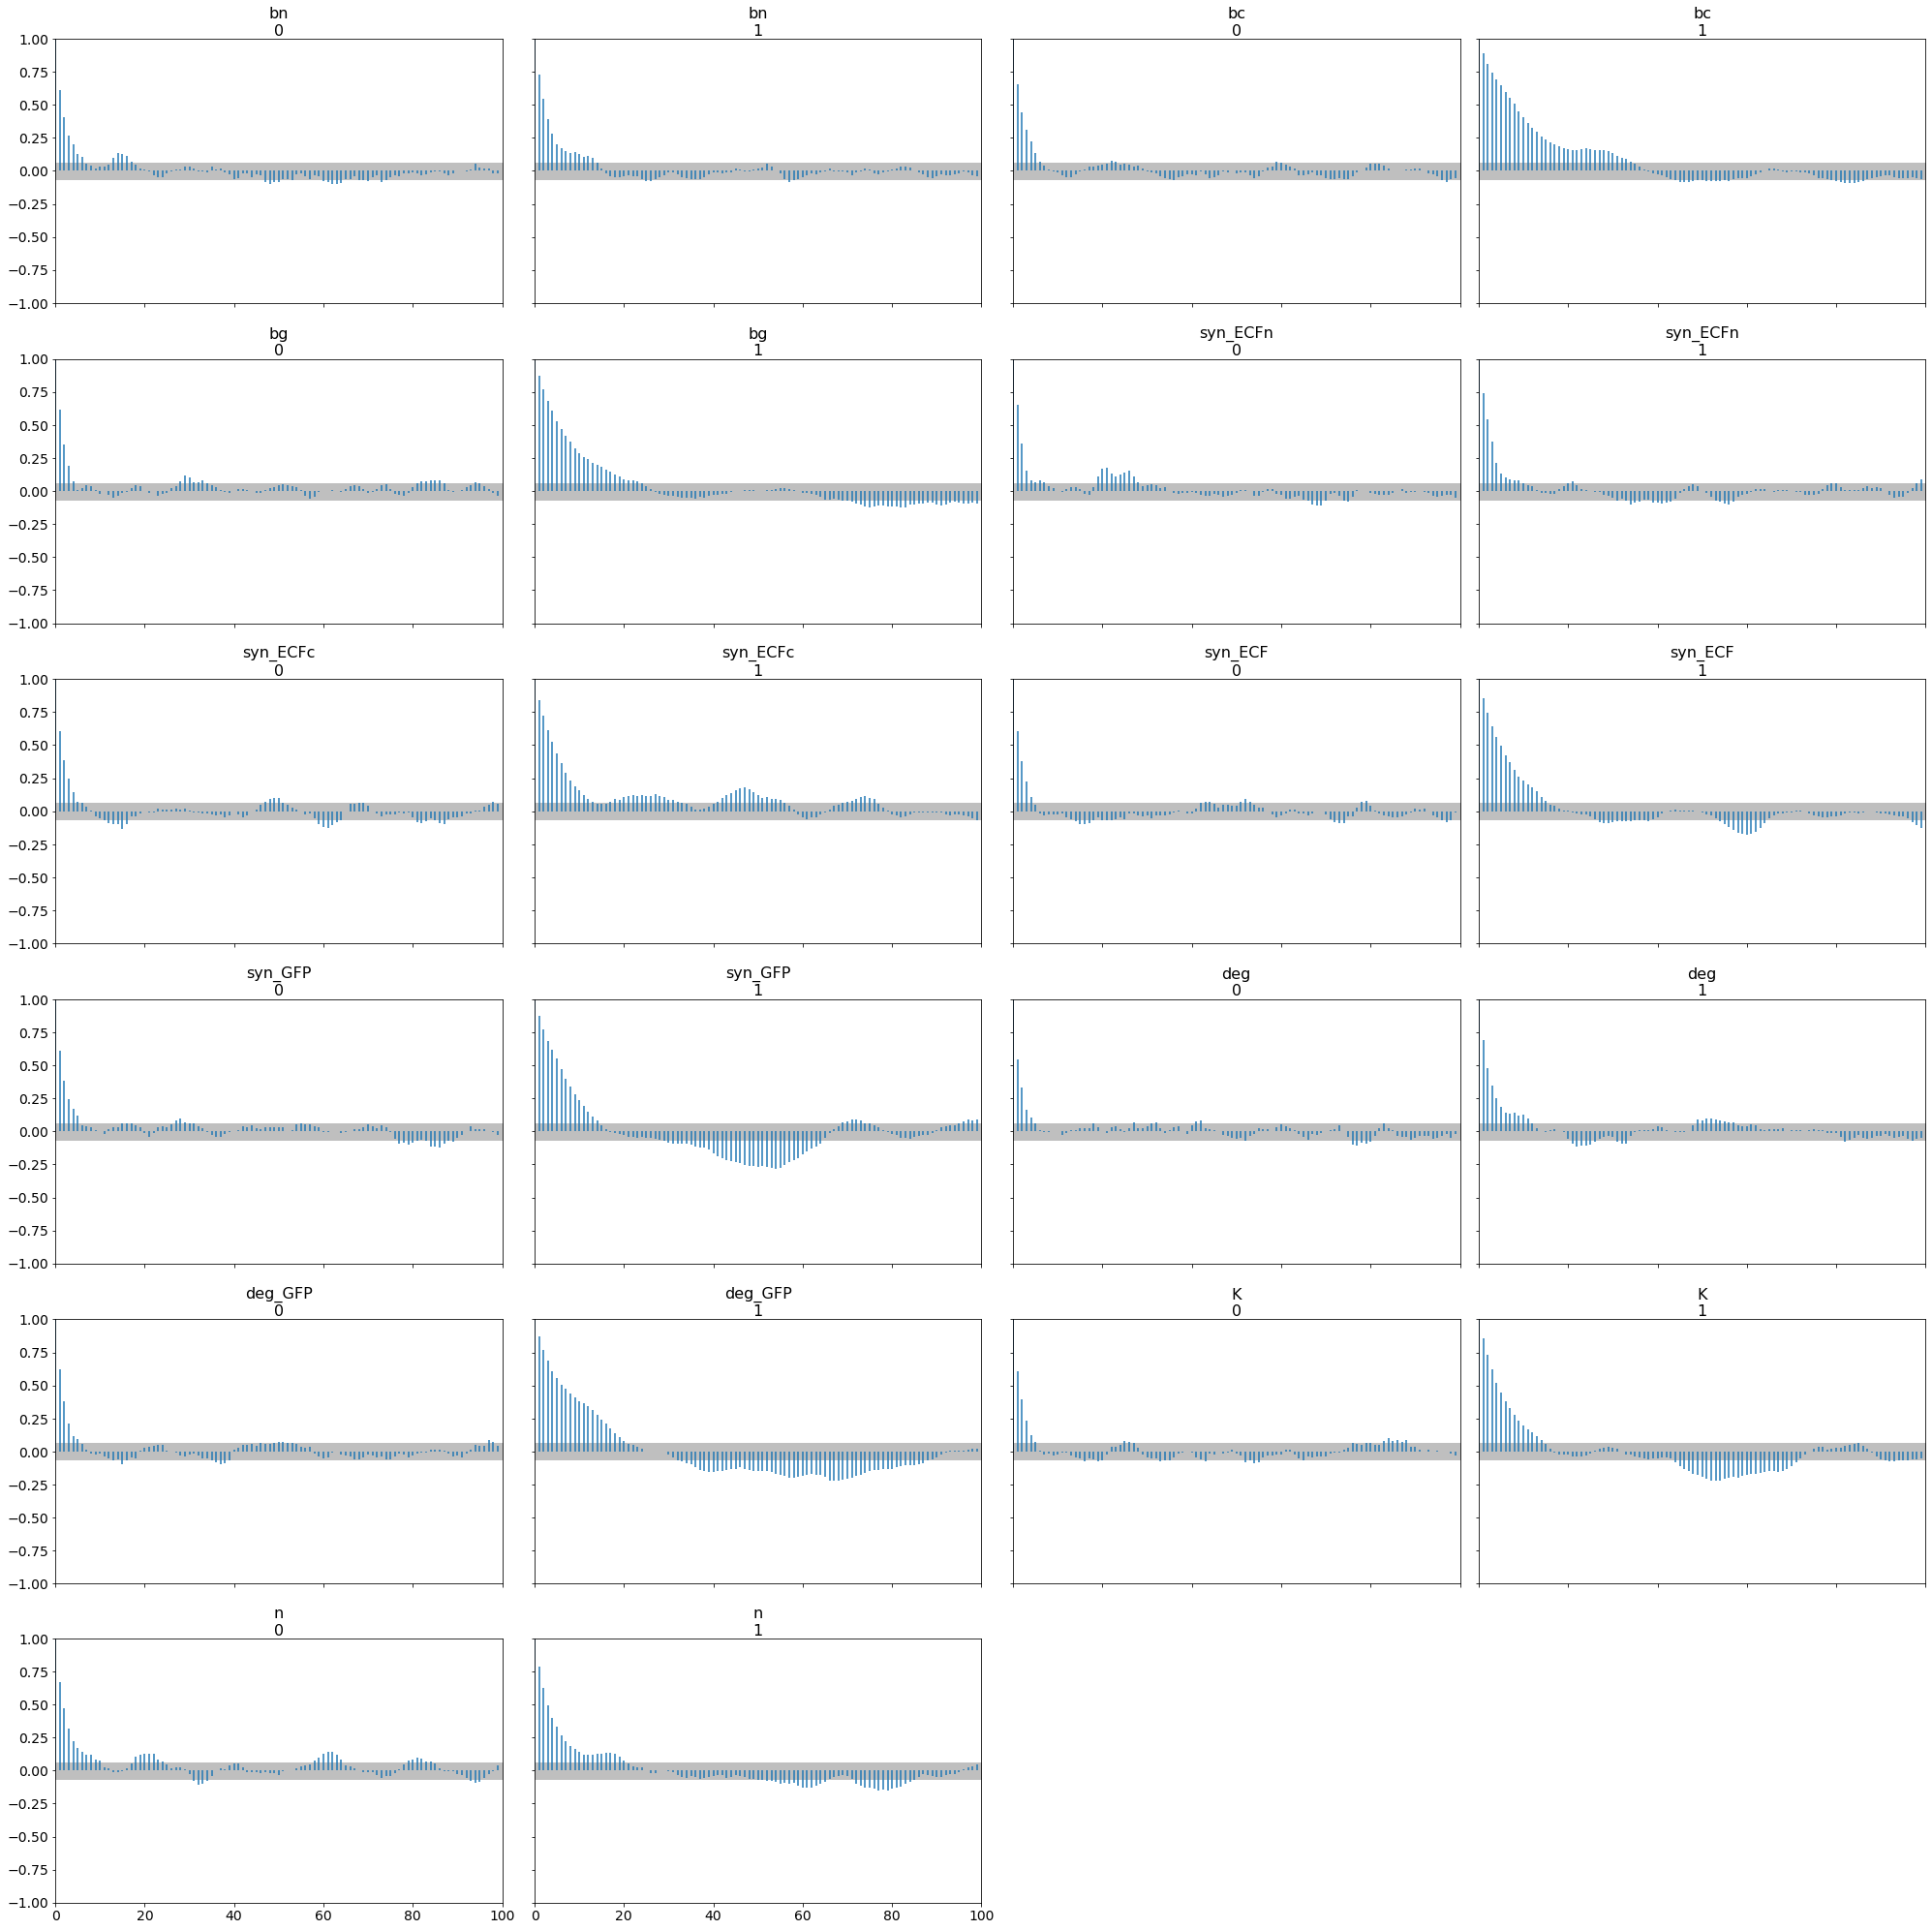

In [25]:
az.plot_autocorr(loaded)
plt.show()

In [ ]:
bn	9.987172e+00	6.260265e+01
1	bc	4.883389e+00	2.852031e+01
2	bg	5.344180e+00	1.805993e+00
3	syn_ECFn	9.999531e+01	4.321537e+01
4	syn_ECFc	5.096548e+01	1.005362e+02
5	syn_ECF	1.581679e-08	7.390481e-08
6	syn_GFP	1.179393e-02	1.144958e-02
7	deg	7.513354e+03	8.551361e-02
8	deg_GFP	2.984798e-02	6.572396e-02
9	K	4.898191e+01	3.087793e+01
10	n	2.563336e+00	1.181155e+01


In [83]:
fix_par = {'bn': 9.999999999976385,
 'bc': 4.884941174143677,
 'bg': 5.364135672597076,
 'syn_ECFn': 99.9999999999739,
 'syn_ECFc': 50.97696503335078,
 'syn_ECF': 1.576133462199827e-08,
 'syn_GFP': 0.011953121728744096,
 'deg': 7.398089262804092e3,
 'deg_GFP': 3.074861557143704e-2,
 'K': 48.96930082383338,
 'n': 2.5313510745154546}

In [87]:
mean_pars

{'bn': 9.999999999976385,
 'bc': 4.884941174143677,
 'bg': 4.964135672597076,
 'syn_ECFn': 99.9999999999739,
 'syn_ECFc': 50.97696503335078,
 'syn_ECF': 4.576133462199827e-05,
 'syn_GFP': 0.049953121728744096,
 'deg': 5.398089262804092e-16,
 'deg_GFP': 0.5074861557143704,
 'K': 48.96930082383338,
 'n': 2.5313510745154546}

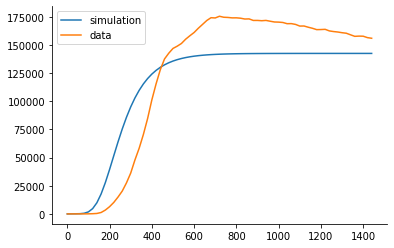

In [84]:
plt.plot(fluo.index, model_fit(fluo.index, *list(fix_par.values())), label='simulation')
plt.plot(fluo.index, fluo, label='data')
plt.legend()
sns.despine()

In [ ]:
plt.plot(od.index, od_inference(od.index, alpha.mean(), beta.mean(), c0.mean()))
plt.plot(od.index, od)
sns.despine()